In [2]:
import os, glob
import csv
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import plotter
sns.set()

In [3]:
class MyRnn(nn.Module):
  def __init__(self, in_d=2, out_d=2, hidden_d=4, num_hidden=1):
    super(MyRnn, self).__init__()
    self.rnn = nn.RNN(input_size=in_d, hidden_size=hidden_d, num_layers=num_hidden)
    self.fc = nn.Linear(hidden_d, out_d)

  def forward(self, x, h0):
    r, h = self.rnn(x, h0)
    y = self.fc(r)  # no activation on the output
    return y, h

In [10]:
data = []
with open('aim_data/sample1.txt') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        x = float(row[1])
        y = float(row[2])
        data.append([x,y])
print(data)
tensor = torch.FloatTensor(data)[:,None,:]

[[1136.0, 771.0], [1136.0, 770.0], [1136.0, 769.0], [1136.0, 768.0], [1136.0, 766.0], [1136.0, 765.0], [1136.0, 764.0], [1136.0, 763.0], [1136.0, 762.0], [1136.0, 761.0], [1136.0, 760.0], [1136.0, 759.0], [1136.0, 758.0], [1136.0, 757.0], [1136.0, 756.0], [1136.0, 755.0], [1136.0, 754.0], [1136.0, 753.0], [1136.0, 752.0], [1136.0, 751.0], [1136.0, 750.0], [1134.0, 750.0], [1134.0, 749.0], [1134.0, 748.0], [1134.0, 747.0], [1133.0, 747.0], [1133.0, 747.0], [1133.0, 746.0], [1132.0, 745.0], [1132.0, 744.0], [1132.0, 743.0], [1131.0, 743.0], [1131.0, 742.0], [1131.0, 740.0], [1131.0, 739.0], [1131.0, 738.0], [1131.0, 737.0], [1130.0, 737.0], [1130.0, 736.0], [1130.0, 735.0], [1130.0, 734.0], [1130.0, 733.0], [1130.0, 732.0], [1130.0, 731.0], [1130.0, 730.0], [1130.0, 729.0], [1130.0, 728.0], [1130.0, 727.0], [1129.0, 727.0], [1129.0, 726.0], [1129.0, 725.0], [1129.0, 724.0], [1129.0, 723.0], [1129.0, 722.0], [1129.0, 721.0], [1129.0, 720.0], [1129.0, 719.0], [1128.0, 719.0], [1128.0, 718.

In [5]:
folder = "aim_data"

file_paths = glob.glob(folder + '/*')

def numbers(s):
    return int(s.split(".")[0][15:])

file_paths.sort(key=numbers)

sequences = []
for file_path in file_paths:
    if file_path == "aim_data/sample1.txt":
        testing = True
    else:
        testing = False
    
    data = []
    with open(file_path) as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if testing:
                print(row)
            x = float(row[1])
            y = float(row[2])
            data.append([x,y])
    
    tensor = torch.FloatTensor(data)[:,None,:]

    mu = tensor.mean(dim=0)
    if testing:
        print(mu)
    std = tensor.std(dim=0)
    if testing:
        print(std)
    if testing:
        print((tensor-mu)/std)
    sequences.append((tensor-mu)/std)
    if testing:
        print(((sequences[-1])*std)+mu)



['0', '1136', '771']
['2', '1136', '770']
['3', '1136', '769']
['5', '1136', '768']
['7', '1136', '766']
['9', '1136', '765']
['13', '1136', '764']
['16', '1136', '763']
['20', '1136', '762']
['23', '1136', '761']
['25', '1136', '760']
['27', '1136', '759']
['31', '1136', '758']
['34', '1136', '757']
['37', '1136', '756']
['40', '1136', '755']
['44', '1136', '754']
['47', '1136', '753']
['51', '1136', '752']
['56', '1136', '751']
['59', '1136', '750']
['60', '1134', '750']
['63', '1134', '749']
['68', '1134', '748']
['74', '1134', '747']
['86', '1133', '747']
['211', '1133', '747']
['213', '1133', '746']
['218', '1132', '745']
['220', '1132', '744']
['225', '1132', '743']
['230', '1131', '743']
['231', '1131', '742']
['235', '1131', '740']
['240', '1131', '739']
['248', '1131', '738']
['250', '1131', '737']
['256', '1130', '737']
['257', '1130', '736']
['260', '1130', '735']
['268', '1130', '734']
['272', '1130', '733']
['277', '1130', '732']
['282', '1130', '731']
['288', '1130', '730

In [6]:
def custom_loss(pred, actual):
    diff = torch.pow(pred - actual, 2)
    mean_diff = torch.mean(diff)
    return mean_diff

100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


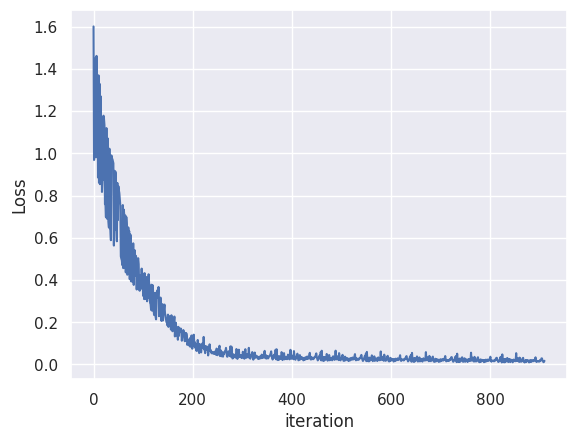

In [7]:
in_d = 2
out_d = in_d
hidden_d = 8
num_hidden = 1
rnn = MyRnn(in_d, out_d, hidden_d, num_hidden)
loss = []
# criterion = custom_loss
criterion = nn.MSELoss()
opt = torch.optim.SGD(rnn.parameters(), lr=0.01)
n_epochs = 10
for e in trange(n_epochs):
  for s in sequences:
    pred, _ = rnn(s[:-1,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # predict next step, init hidden state to zero at the begining of the sequence
    err = criterion(pred, s[1:, ...])  # predict next step for each step
    opt.zero_grad()
    err.backward()
    opt.step()
    loss.append(err.item())
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [8]:
rnn.eval()
with torch.no_grad():
  k = 5 
  for si, s in enumerate(sequences):
    pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
    print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
    prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
    # continue to predict 
    for j in  range(k+1, s.shape[0]):
      pred, h = rnn(prev, h)
      print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
      prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')

NameError: name 'sig' is not defined

In [32]:
len(sequences[0:1])

1

seq 0, prev = tensor([[680.3098, 704.1416]])  -> predicted 5th step = tensor([[680.4744, 703.5580]]), actual step = tensor([[680.3098, 703.9613]])
		predicted step 6 (prev = tensor([[[680., 704.]]])) = tensor([[680.0687, 703.3394]]), actual step = tensor([[680.3098, 703.7811]])
		predicted step 7 (prev = tensor([[[680., 703.]]])) = tensor([[680.0752, 702.8338]]), actual step = tensor([[680.3098, 703.6008]])
		predicted step 8 (prev = tensor([[[680., 703.]]])) = tensor([[679.9758, 702.7446]]), actual step = tensor([[680.3098, 703.4205]])
		predicted step 9 (prev = tensor([[[680., 703.]]])) = tensor([[679.9133, 702.7505]]), actual step = tensor([[680.3098, 703.2402]])
		predicted step 10 (prev = tensor([[[680., 703.]]])) = tensor([[679.9044, 702.7733]]), actual step = tensor([[680.3098, 703.0599]])
		predicted step 11 (prev = tensor([[[680., 703.]]])) = tensor([[679.9210, 702.7871]]), actual step = tensor([[680.3098, 702.8796]])
		predicted step 12 (prev = tensor([[[680., 703.]]])) = ten

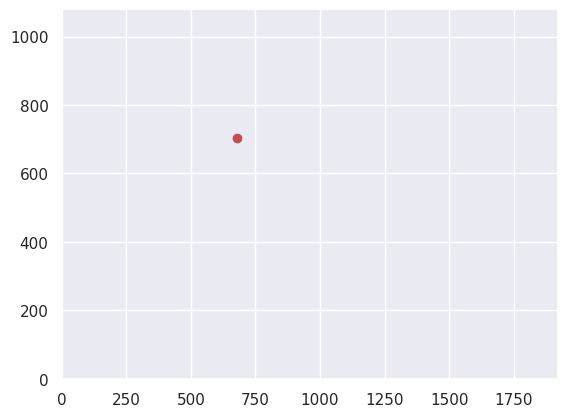

Point 680.0686645507812,703.3394165039062 to 680.0751953125,702.8338012695312
Point 680.0751953125,702.8338012695312 to 679.975830078125,702.74462890625
Point 679.975830078125,702.74462890625 to 679.913330078125,702.75048828125
Point 679.913330078125,702.75048828125 to 679.9043579101562,702.7732543945312
Point 679.9043579101562,702.7732543945312 to 679.9210205078125,702.787109375
Point 679.9210205078125,702.787109375 to 679.9364624023438,702.7894287109375
Point 679.9364624023438,702.7894287109375 to 679.9420166015625,702.786376953125
Point 679.9420166015625,702.786376953125 to 679.9407958984375,702.7833251953125
Point 679.9407958984375,702.7833251953125 to 679.9379272460938,702.7821044921875
Point 679.9379272460938,702.7821044921875 to 679.936279296875,702.7822875976562
Point 679.936279296875,702.7822875976562 to 679.93603515625,702.7828369140625
Point 679.93603515625,702.7828369140625 to 679.9364624023438,702.783203125
Point 679.9364624023438,702.783203125 to 679.9368286132812,702.783

In [47]:
with torch.no_grad():
  coord = []
  k = 5 
  for si, s in enumerate(sequences):
    
    if si == 0:
      pred, h = rnn(s[:k,...], torch.zeros(num_hidden, 1, hidden_d, dtype=torch.float))  # given first k steps predict the next one
      coord.append(pred[-1, ...]*sig + mu)
      print('seq {}, prev = {}  -> predicted {}th step = {}, actual step = {}'.format(si, s[k-1,...]*sig+mu, k, pred[-1, ...]*sig + mu, s[k, ...]*sig+mu))
      prev = (torch.round(pred[-1:, ...]*sig + mu) - mu) / sig  # round the prediction, attmepting to avoid accumulation of error
      # continue to predict 
      for j in  range(k+1, s.shape[0]):
        pred, h = rnn(prev, h)
        coord.append(pred[-1, ...]*sig + mu)
        print('\t\tpredicted step {} (prev = {}) = {}, actual step = {}'.format(j, prev*sig+mu, pred[-1,...]*sig+mu, s[j, ...]*sig + mu))
        prev = (torch.round(pred*sig + mu) - mu) / sig
  print('\n')

coord = [x.tolist()[0] for x in coord]
plotter.mousePlotWithList(coord)